# Predictive Analytics

In [1]:
# Import packages for Data Wranglings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

# Import packages for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# Import data from task 1
data = pd.read_pickle("/content/drive/MyDrive/ANZ/data.pkl")
data.head()

,status,card_present_flag,account,long_lat,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement,month,dayofweek,hour,category
0,authorized,1,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,01:01:15,16.25,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit,8,2,1,Purchase
1,authorized,0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,26,Sydney,NSW,01:13:45,14.19,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit,8,2,1,Purchase
2,authorized,1,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,M,38,Sydney,NSW,01:26:15,6.42,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit,8,2,1,Purchase
3,authorized,1,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,01:38:45,40.90,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit,8,2,1,Purchase
4,authorized,1,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,01:51:15,3.25,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit,8,2,1,Purchase


In [3]:
pd.DataFrame({"Columns": data.columns})

,Columns
0,status
1,card_present_flag
2,account
3,long_lat
4,txn_description
5,merchant_id
6,first_name
7,balance
8,date
9,gender


In [4]:
salary_df = pd.DataFrame({"customer_id": data.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [5]:
# Example of amount purchased by a customer, by date
example = data.loc[(data.customer_id == salary_df.customer_id[0]) & (data.txn_description
                   == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index=False).sum()
example

,date,amount
0,2018-08-01,1013.67
1,2018-08-08,1013.67
2,2018-08-15,1013.67
3,2018-08-22,1013.67
4,2018-08-29,1013.67
5,2018-09-05,1013.67
6,2018-09-12,1013.67
7,2018-09-19,1013.67
8,2018-09-26,1013.67
9,2018-10-03,1013.67


In [6]:
# Loop through all salary payments for each customer
# Assume the salary level is constant for each customer over the observed period
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
  salary = data.loc[(data.customer_id == salary_df.customer_id
                     [customer]) & (data.txn_description=="PAY/SALARY"),["date","amount"]].groupby(
                         "date", as_index=False).sum()
  count = len(salary)
  if count == 0: # If count = 0, append NaN
    df_amount.append(np.nan)
    df_freq.append(np.nan)
  else:
    days_between_payments = []
    for date in range(len(salary)-1):
      days_between_payments.append((salary.date[date+1] - salary.date[date]).days)
    df_freq.append(max(days_between_payments))
    df_amount.append(mode(salary.amount)) #  mode is the value that appears most often in a set of data values

# Adding df to the DataFrame
salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount
salary_df["annual_salary"] = salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Annual Salary')

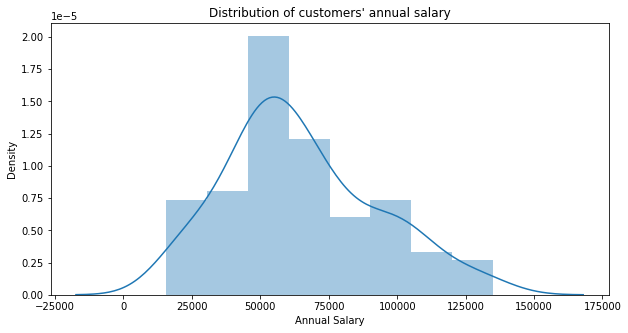

In [7]:
# Plot customer's annual salary distribution
plt.figure(figsize=(10,5))
sns.distplot(salary_df.annual_salary)
plt.title("Distribution of customers' annual salary")
plt.xlabel("Annual Salary")

## Predictor Variables
- Average number of weekly transactions
- Maximum transaction amount
- Number of large transactions (over $100)
- Number of days with transactions
- Average transaction amount
- Median balance
- State of residence

In [8]:
# Unique customer id
unique_id = data.customer_id.unique()
len(unique_id)

100

In [9]:
unique_id[:10]

array(['CUS-2487424745', 'CUS-2142601169', 'CUS-1614226872',
       'CUS-2688605418', 'CUS-4123612273', 'CUS-3026014945',
       'CUS-2031327464', 'CUS-2317998716', 'CUS-1462656821',
       'CUS-3142625864'], dtype=object)

In [10]:
# Average number of weekly transactions
avg_no_weekly_trans = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "date"]
  avg_no_weekly_trans.append(round(len(array)/array.nunique()*7))
avg_no_weekly_trans[:5]

[48, 29, 24, 14, 21]

In [11]:
# Maximum amount
max_amount = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "amount"]
  max_amount.append(max(array))
max_amount[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

In [12]:
# Number of large transactions
no_large_trans = []
for id_ in unique_id:
  count = 0
  array = data.loc[data.customer_id == id_, "amount"]
  for amount in array:
    if amount > 100:
      count += 1
  no_large_trans.append(count)
no_large_trans[:5]

[22, 23, 22, 25, 32]

In [13]:
# Number of days with transactions
no_days_with_trans = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "date"]
  no_days_with_trans.append(array.nunique())
no_days_with_trans[:5]

[85, 74, 76, 63, 44]

In [14]:
# Average transaction amount
avg_trans_amount = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "amount"]
  avg_trans_amount.append(array.mean())
avg_trans_amount[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

In [15]:
# Median balance
median_balance = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "balance"]
  median_balance.append(array.median())
median_balance[:5]

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

In [17]:
# State of residence
# Assume customer live in the state where most of their transactions occured
state = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "merchant_state"]
  state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

In [18]:
# Include age and gender from original dataframe
age = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "age"]
  age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

In [19]:
gender = []
for id_ in unique_id:
  array = data.loc[data.customer_id == id_, "gender"]
  gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

## Putting everything together

In [20]:
# Predictor variables
features_df = pd.DataFrame({"customer_id": unique_id,
                            "avg_no_weekly_trans": avg_no_weekly_trans,
                            "max_amount" : max_amount,
                            "no_large_trans": no_large_trans,
                            "avg_trans_amount": avg_trans_amount,
                            "median_balance": median_balance,
                            "state": state,
                            "age": age,
                            "gender": gender
                            })
features_df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F


In [21]:
# Target variable
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


In [22]:
# Concatenate annual salary column to features dataframe
df = pd.concat([features_df, salary_df.annual_salary], axis=1)
df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F,52891.852500
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M,52289.711786
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F,46547.981786
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M,60534.969643
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F,55728.801429


In [23]:
# Check for missing values
df.isnull().sum()

customer_id            0
avg_no_weekly_trans    0
max_amount             0
no_large_trans         0
avg_trans_amount       0
median_balance         0
state                  0
age                    0
gender                 0
annual_salary          0
dtype: int64

## Preprocessing

In [24]:
# Train test split
X = df.drop(["customer_id", "annual_salary"], axis=1)
y = df.annual_salary
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (100, 8)
y shape:  (100,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (70, 8)
X_test shape:  (30, 8)
y_train shape:  (70,)
y_test shape:  (30,)


In [27]:
# One-hot encoder and StandardScaler
ohe = OneHotEncoder(sparse=False) # for categorical value
scaler = StandardScaler() # for numerical value
column_transform = make_column_transformer((ohe, ["state", "gender"]), 
                                           (scaler, ["avg_no_weekly_trans", "max_amount",
                                                     "no_large_trans", "avg_trans_amount",
                                                     "median_balance", "age"]))

## Predict customer annual salary

In [28]:
# Linear Regression
lm = LinearRegression()
lm_pipeline = make_pipeline(column_transform, lm)

In [29]:
# Fit pipeline and make predictions
lm_pipeline.fit(X_train, y_train)
lm_pred = lm_pipeline.predict(X_test)

In [30]:
# RMSE
print("RMSE: ", round(np.sqrt(mean_squared_error(lm_pred, y_test))))

RMSE:  27836


In [32]:
# Decision Tree
tree = DecisionTreeRegressor()
tree_pipeline = make_pipeline(column_transform, tree)

In [33]:
# Fit pipeline and make predictions
tree_pipeline.fit(X_train, y_train)
tree_pred = tree_pipeline.predict(X_test)

In [34]:
# RMSE
print("RMSE: ", round(np.sqrt(mean_squared_error(tree_pred, y_test))))

RMSE:  20566
